# Enhanced patient trial matching

In [1]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

PROJECT_DIR = Path.home() / "github" / "llm-drug-discovery"
DATA_DIR = PROJECT_DIR / "data"
PLOTS_DIR = PROJECT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def load_json(path: Path):
    return json.loads(path.read_text())


def patient_to_text(p):
    return f"{p['demographics']}. {p['medical_history']}"


def trial_to_text(t):
    c = t["eligibility_criteria"]
    parts = [
        f"Age between {c['age_min']} and {c['age_max']} years",
        f"Ejection fraction between {c['ef_min']}% and {c['ef_max']}%",
        f"Serum creatinine between {c['creatinine_min']} and {c['creatinine_max']} mg/dL",
        f"Serum sodium between {c['sodium_min']} and {c['sodium_max']} mEq/L",
    ]
    for key, label in [
        ("anaemia", "anaemia"),
        ("diabetes", "diabetes"),
        ("high_blood_pressure", "high blood pressure"),
        ("smoking", "smoking"),
    ]:
        if c.get(key) is not None:
            parts.append(f"{'With' if c[key] == 1 else 'Without'} {label}")
    if c.get("sex") is not None:
        parts.append("Male patients only" if c["sex"] == 1 else "Female patients only")
    return " ".join(parts)


def embed_texts(texts, tokenizer, model, device="cpu", batch_size=16):
    all_emb = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        input_ids = enc.input_ids.to(device)
        attn_mask = enc.attention_mask.to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            emb = (
                outputs.pooler_output
                if hasattr(outputs, "pooler_output")
                else outputs.last_hidden_state[:, 0, :]
            )
        all_emb.append(emb.cpu().numpy())
    return np.vstack(all_emb)


def match_by_bert(pt_texts, tr_texts, tokenizer, model, threshold=0.5, device="cpu"):
    p_emb = embed_texts(pt_texts, tokenizer, model, device)
    t_emb = embed_texts(tr_texts, tokenizer, model, device)
    sims = cosine_similarity(t_emb, p_emb)
    matches = {
        i: np.where(sims[i] >= threshold)[0].tolist() for i in range(len(tr_texts))
    }
    return matches, sims


def evaluate(preds, actual):
    tp = len(set(preds) & set(actual))
    fp = len(set(preds) - set(actual))
    fn = len(set(actual) - set(preds))
    prec = tp / (tp + fp) if tp + fp else 0
    rec = tp / (tp + fn) if tp + fn else 1
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
    return prec, rec, f1

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Best threshold (BERT): 0.2


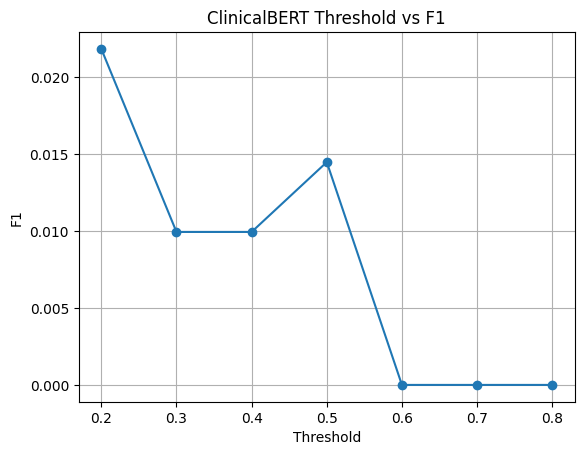

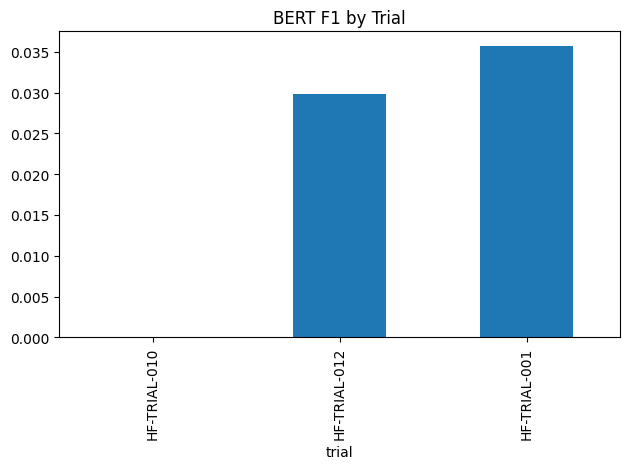

In [3]:
# Load data
patients = load_json(DATA_DIR / "test_patients.json")
trials = load_json(DATA_DIR / "test_trials.json")
pt_texts = [patient_to_text(p) for p in patients]
tr_texts = [trial_to_text(t) for t in trials]
actual = {i: t["eligible_patients"] for i, t in enumerate(trials)}

# Load ClinicalBERT
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
model.eval()

# Threshold tuning
thresholds = np.linspace(0.2, 0.8, 7)
results = []
for thr in thresholds:
    matches, _ = match_by_bert(pt_texts, tr_texts, tokenizer, model, thr, device)
    metrics = [evaluate(matches[i], actual[i]) for i in actual]
    ps, rs, fs = zip(*metrics)
    results.append(
        {
            "threshold": thr,
            "precision": np.mean(ps),
            "recall": np.mean(rs),
            "f1": np.mean(fs),
        }
    )

# Plot F1 vs threshold
df = pd.DataFrame(results)
plt.figure()
plt.plot(df.threshold, df.f1, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("ClinicalBERT Threshold vs F1")
plt.grid(True)
plt.savefig(PLOTS_DIR / "bert_threshold_vs_f1.png")

# Best threshold and final eval
best = max(results, key=lambda x: x["f1"])["threshold"]
print(f"Best threshold (BERT): {best}")
matches, sims = match_by_bert(pt_texts, tr_texts, tokenizer, model, best, device)
eval_data = []
for i in actual:
    p, r, f = evaluate(matches[i], actual[i])
    eval_data.append({"trial": trials[i]["id"], "precision": p, "recall": r, "f1": f})
pd.DataFrame(eval_data).to_csv(DATA_DIR / "bert_matching_eval.csv", index=False)
plt.figure()
pd.DataFrame(eval_data).set_index("trial").f1.plot(kind="bar")
plt.title("BERT F1 by Trial")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "bert_f1_by_trial.png")